In [1]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt
import seaborn as sns

import holidays

import warnings
warnings.filterwarnings('ignore')

In [2]:
schema = {
    "id": "uint32",
    "dropoff_latitude": "float64",
    "dropoff_longitude": "float64",
    "fare_amount": "float64",
    "feat1": "float64",
    "feat2": "float64",
    "feat3": "float64",
    "feat4": "float64",
    "feat5": "float64",
    "feat6": "float64",
    "feat7": "float64",
    "feat8": "float64",
    "feat9": "float64",
    "feat10": "float64",
    "key": "string",
    "passenger_count": "int16",
    "pickup_datetime": "string",
    "pickup_latitude": "float64",
    "pickup_longitude": "float64",
}

In [3]:
data = pd.read_csv("data/r3.csv", dtype=schema)
data.columns = schema.keys()
data.drop(columns="id", inplace=True) # we use key as index

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(1, 11):
    sns.histplot(data[f'feat{i}'], ax=axes[i-1], kde=True)
    axes[i-1].set_title(f'feat{i}')

plt.tight_layout()
plt.show()

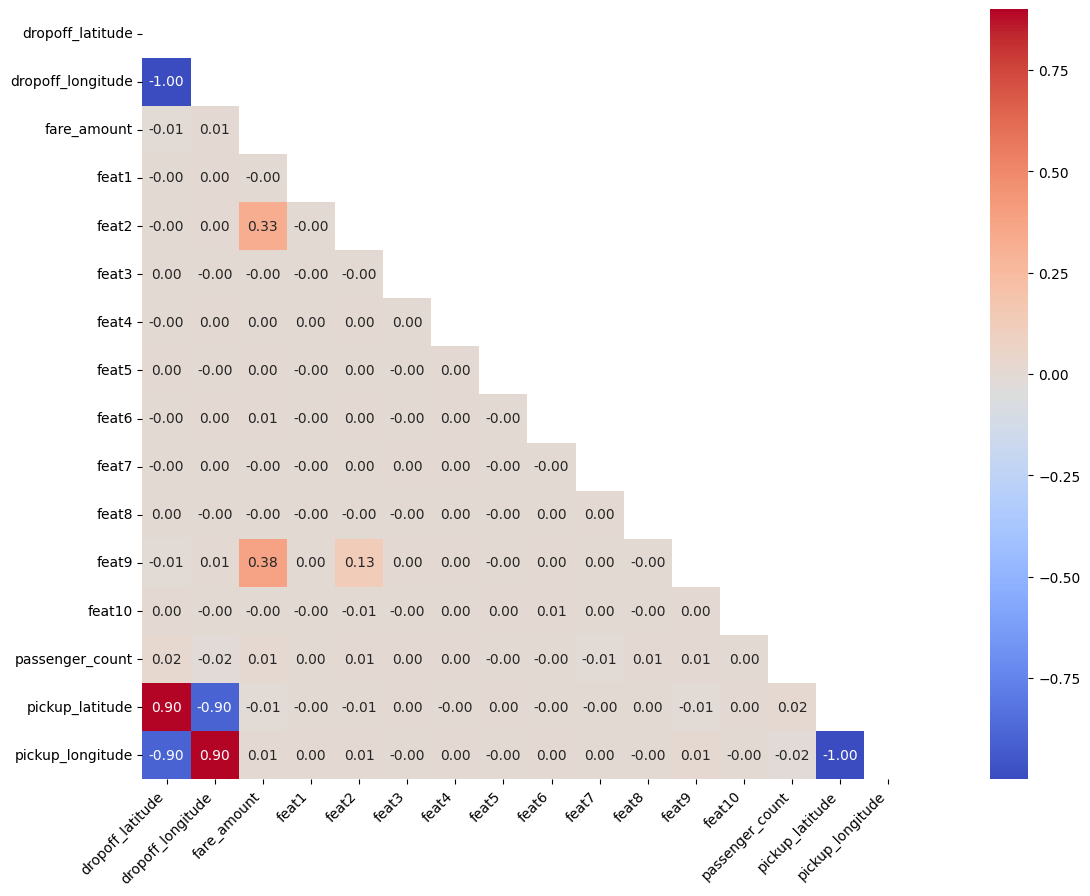

In [5]:
data_numeric = data.select_dtypes(include='number')
corr_matrix = data_numeric.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, mask=mask, cbar=True, square=True, annot=True, fmt='.2f', 
            annot_kws={'size': 10}, cmap='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.show()

fare_amount is almost not correlated to any features besides feat9 and feat2

In [6]:
data["pickup_datetime"] = pd.to_datetime(data["pickup_datetime"], format="%Y-%m-%d %H:%M:%S %Z")
data["pickup_datetime"] = data["pickup_datetime"].dt.tz_localize(None)

data["year"] = data["pickup_datetime"].dt.year
data["month"] = data["pickup_datetime"].dt.month
data["day_of_week"] = data["pickup_datetime"].dt.day_of_week
data["hour"] = data["pickup_datetime"].dt.hour

In [7]:
data["hour_sin"] = np.sin(2 * np.pi * data["hour"] / 24)
data["hour_cos"] = np.cos(2 * np.pi * data["hour"] / 24)

data["month_sin"] = np.sin(2 * np.pi * (data["month"] - 1) / 12)
data["month_cos"] = np.cos(2 * np.pi * (data["month"] - 1) / 12)

data["day_of_week_sin"] = np.sin(2 * np.pi * data["day_of_week"] / 7)
data["day_of_week_cos"] = np.cos(2 * np.pi * data["day_of_week"] / 7)

In [8]:
us_holidays = holidays.US(years=data["year"].unique())
def is_next_day_free(row):
    next_day = row["pickup_datetime"] + pd.Timedelta(days=1)
    if next_day.dayofweek in [4, 5]:
        return 1
    if next_day in us_holidays:
        return 1   
    return 0

data["is_next_day_free"] = data.apply(is_next_day_free, axis=1).astype(int)

In [9]:
data["pickup_date"] = data["pickup_datetime"].dt.floor('D')

oil_data = pd.read_csv("data/oil.csv")
oil_data = oil_data[["Date", "Price"]]
oil_data["Date"] = pd.to_datetime(oil_data["Date"])
oil_data

# # merge oil data
data = pd.merge(data, oil_data, left_on="pickup_date", right_on="Date", how="left")
data.drop(columns=["pickup_date", "Date"], inplace=True)

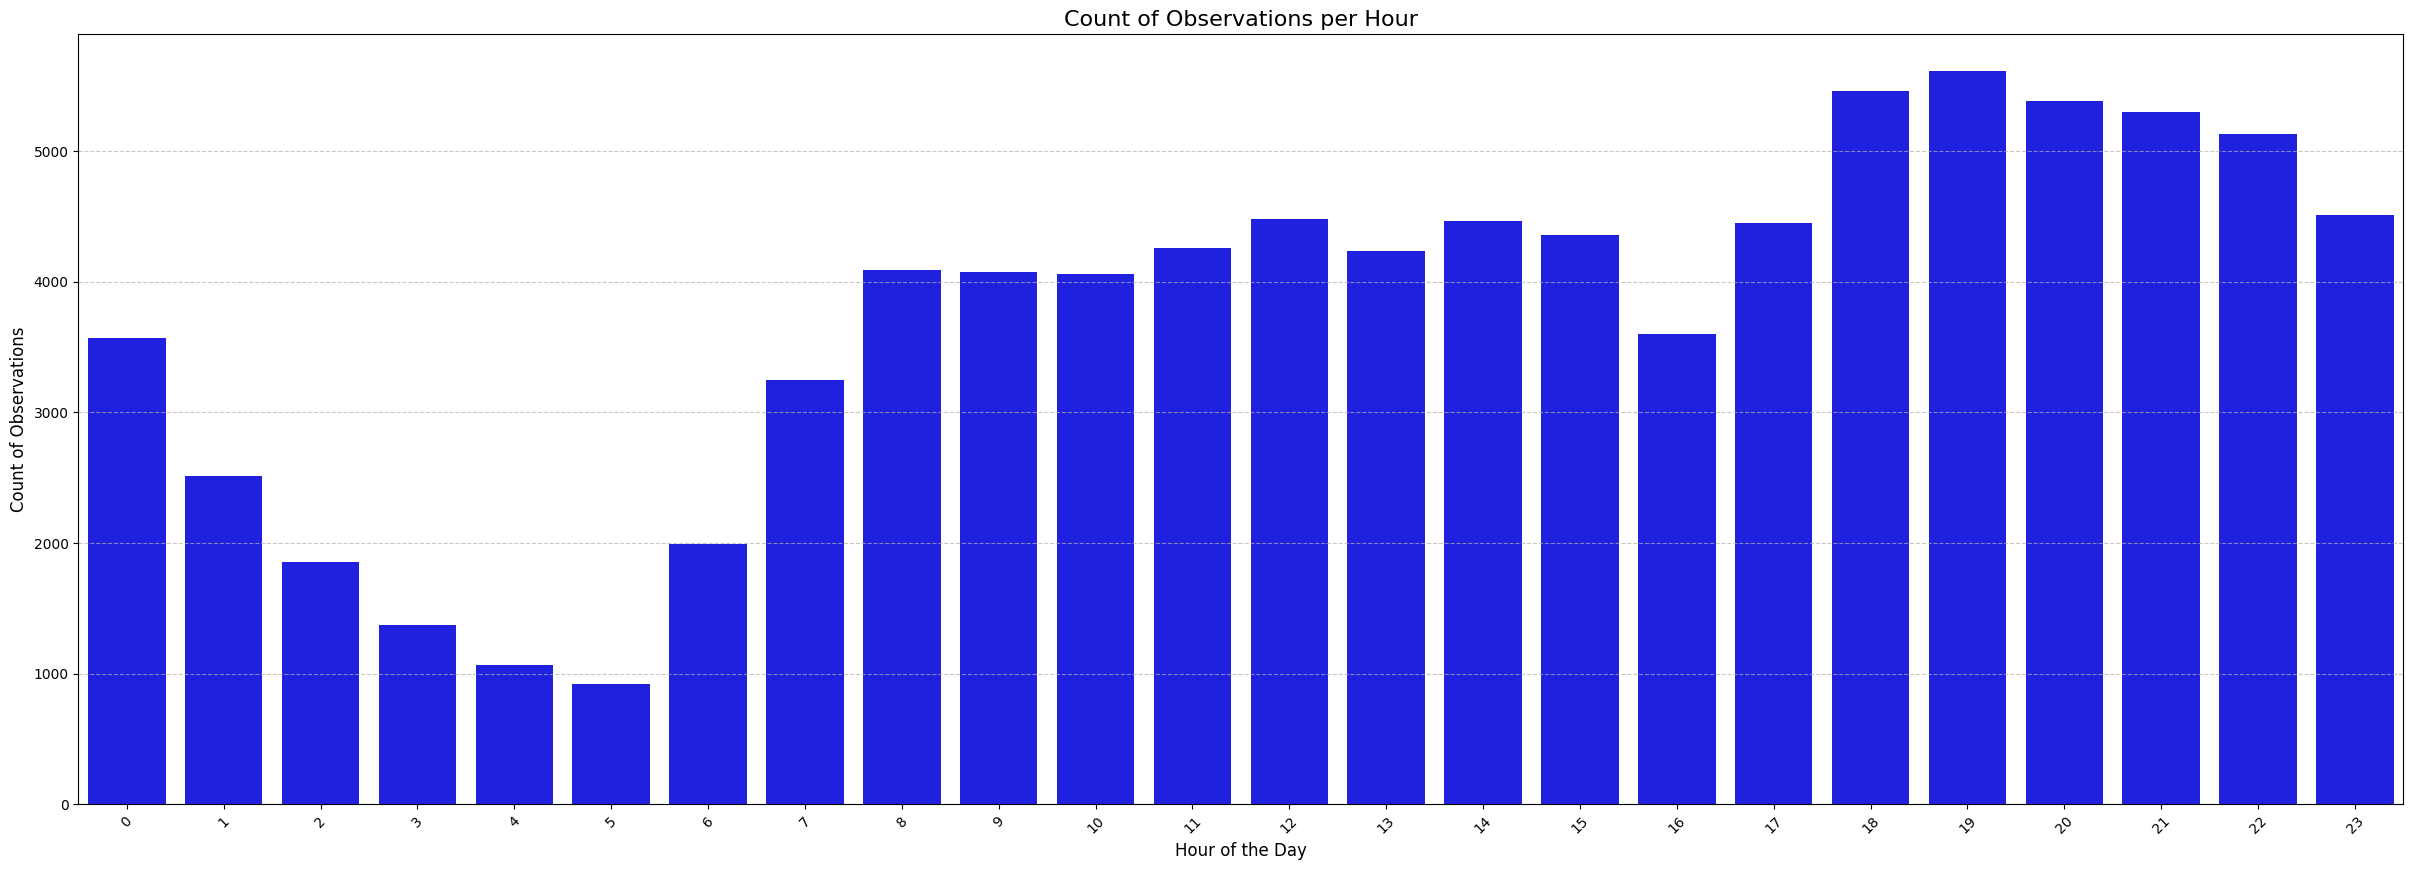

In [10]:
hourly_counts = data["hour"].value_counts().sort_index()

plt.figure(figsize=(30, 10))
sns.barplot(x=hourly_counts.index, y=hourly_counts.values, color='blue')
plt.title("Count of Observations per Hour", fontsize=16)
plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Count of Observations", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

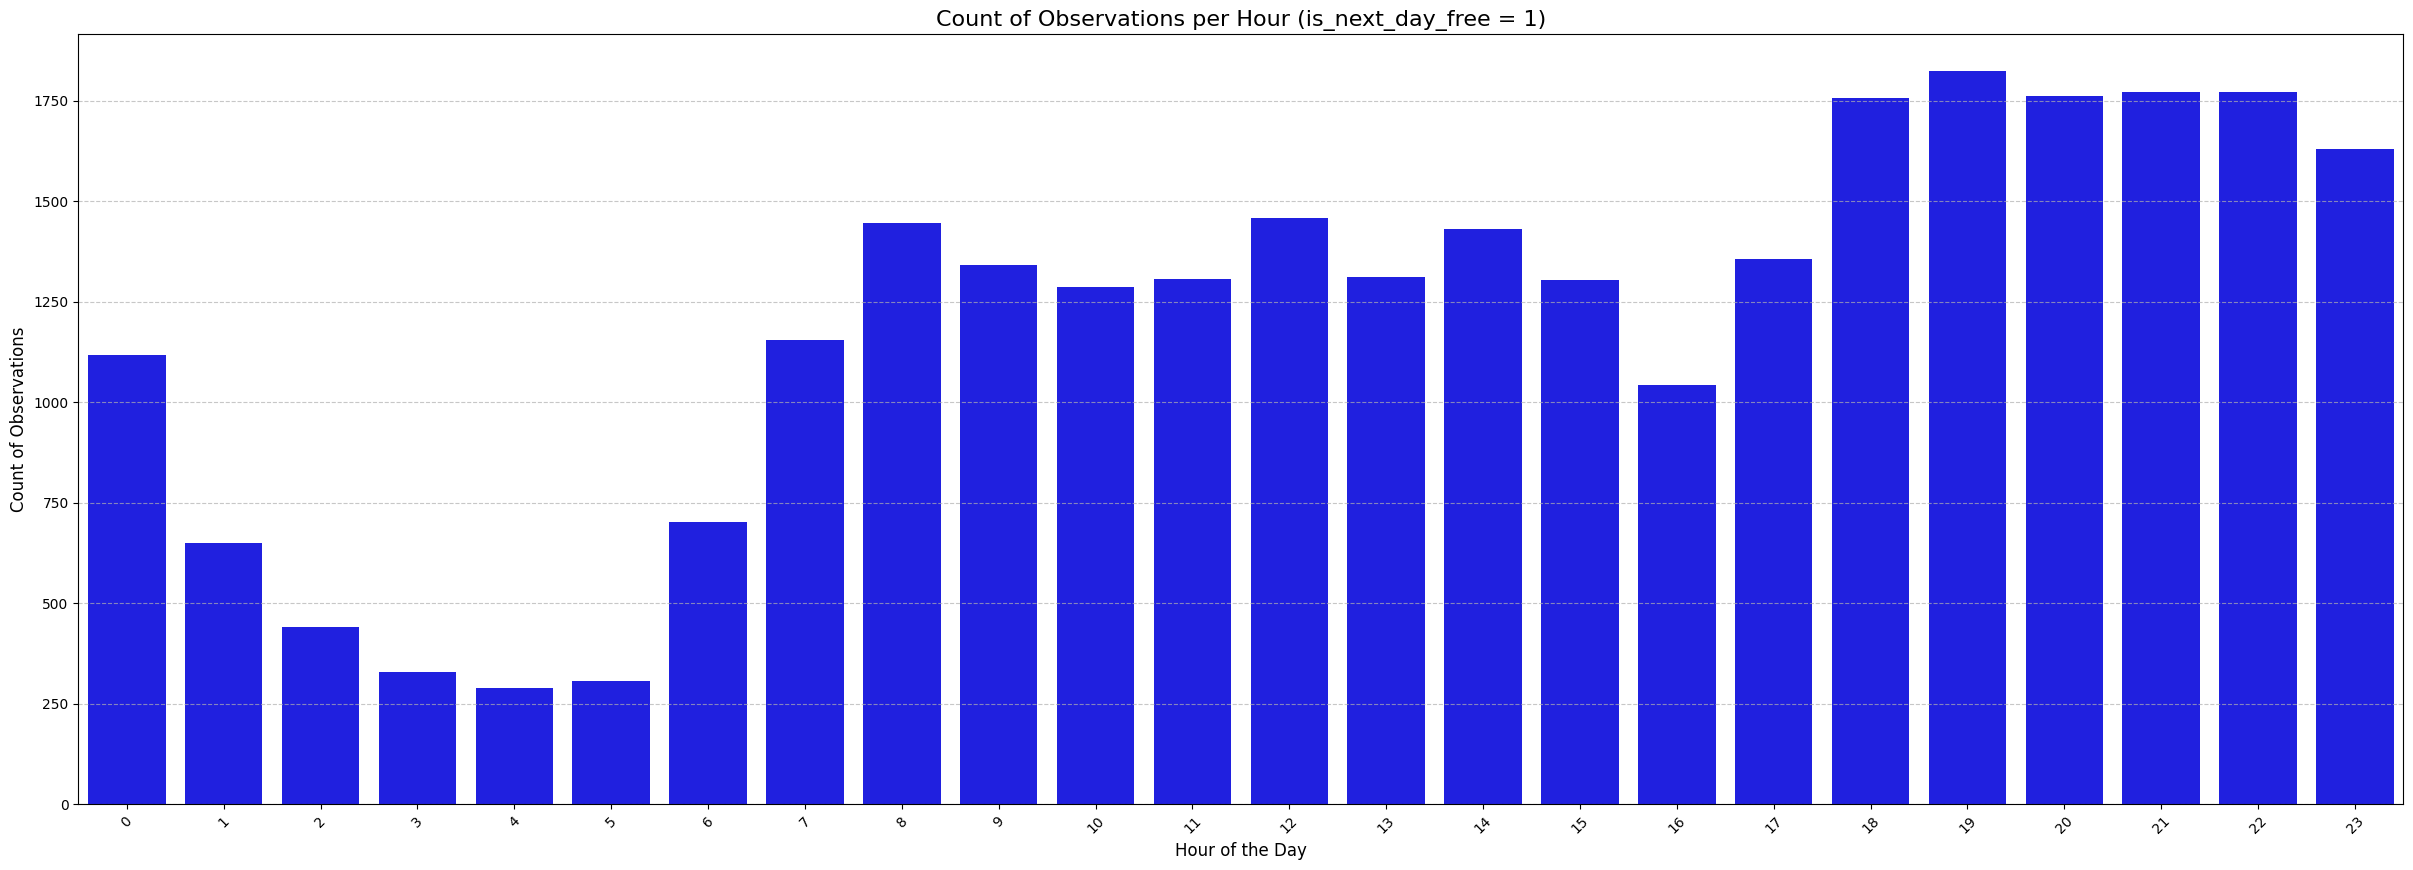

In [11]:
# same plot but for days that are free the next day
filtered_data = data[data["is_next_day_free"] == 1]
hourly_counts = filtered_data["hour"].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(30, 10))
sns.barplot(x=hourly_counts.index, y=hourly_counts.values, color='blue')
plt.title("Count of Observations per Hour (is_next_day_free = 1)", fontsize=16)
plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Count of Observations", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

the peak hours dont change

In [12]:
data["peak_hour"] = ((data["hour"] >= 18) & (data["hour"] <= 22)).astype(int)
data.drop(columns=["hour", "month", "day_of_week", "year"], inplace=True)

In [13]:
#calculate distance between pickup and dropoff
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

data["distance_km"] = haversine_distance(
    data["pickup_latitude"], data["pickup_longitude"],
    data["dropoff_latitude"], data["dropoff_longitude"]
)

In [14]:
# # remove outliers based on longitude and latitude that are outside of NYC
data = data[(data["pickup_latitude"] > 35) & (data["pickup_latitude"] < 44)]
data = data[(data["pickup_longitude"] < -70) & (data["pickup_longitude"] > -78)]
data = data[(data["dropoff_latitude"] > 35) & (data["dropoff_latitude"] < 44)]
data = data[(data["dropoff_longitude"] < -70) & (data["dropoff_longitude"] > -78)]

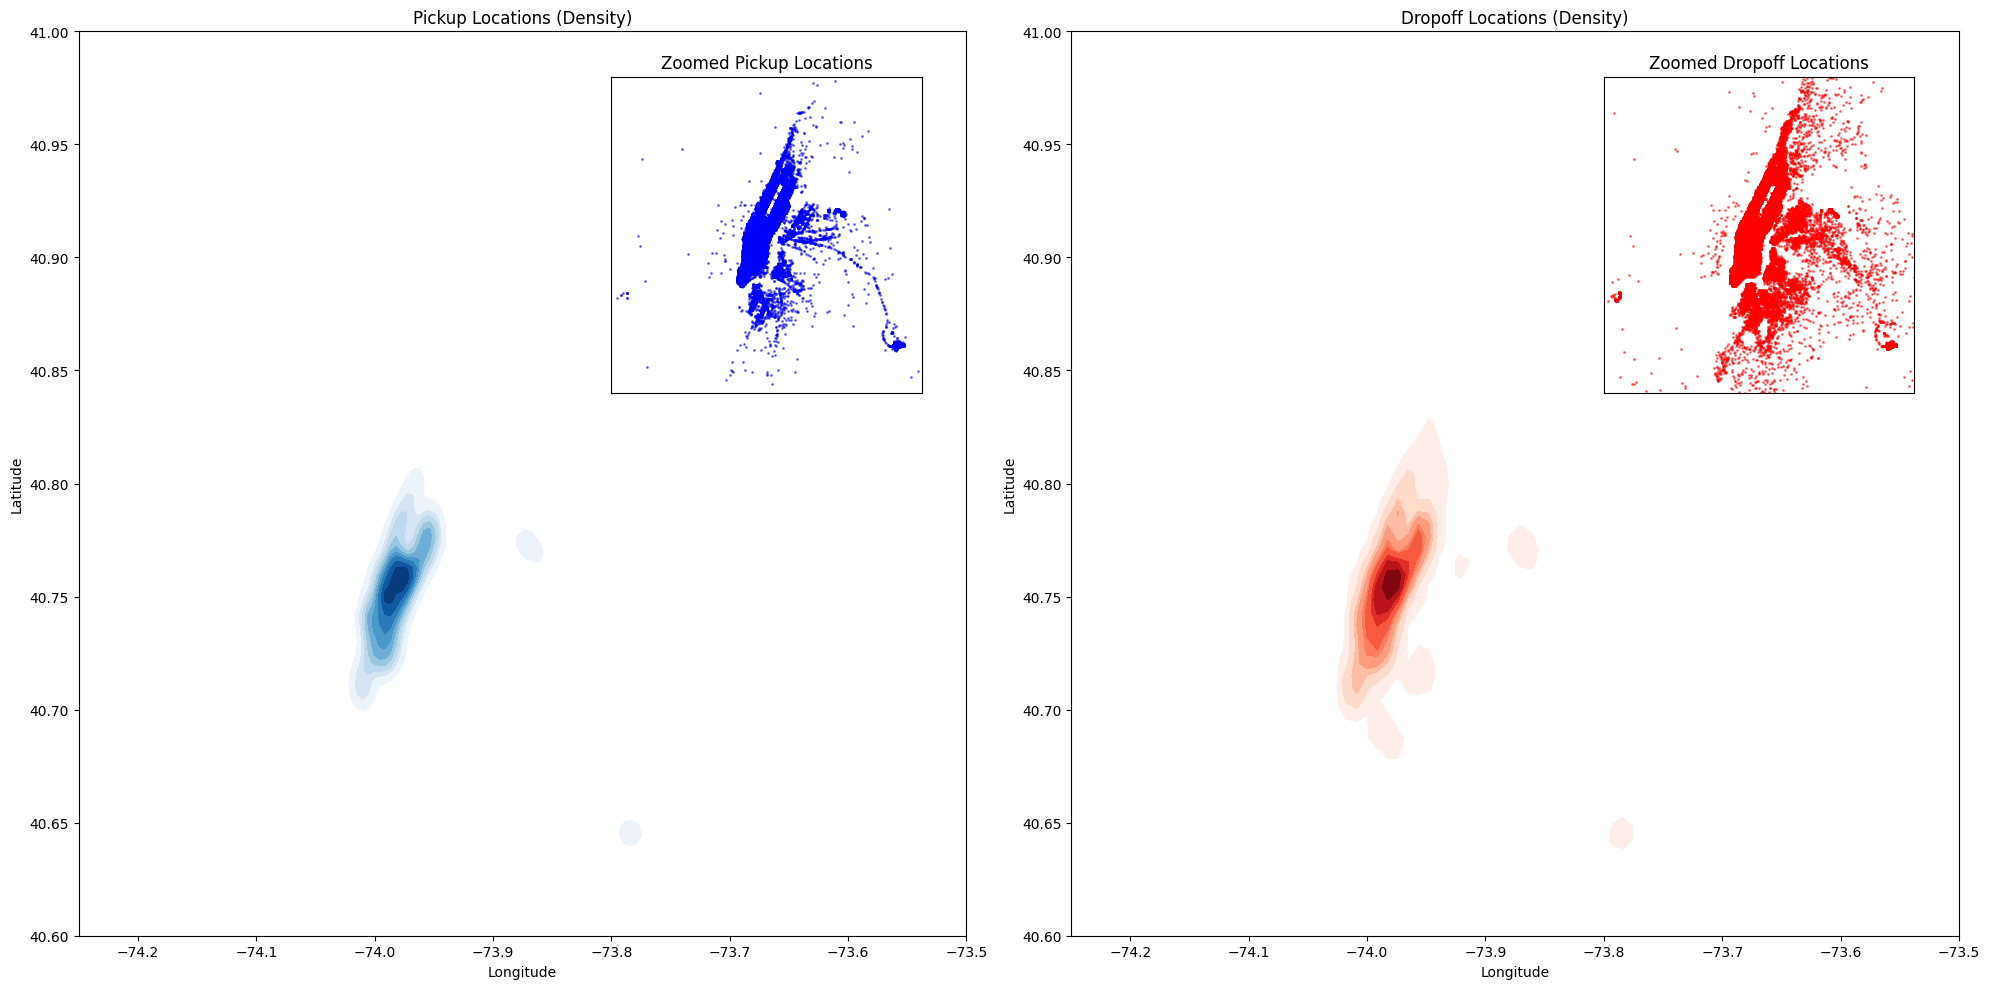

In [15]:
x_range_zoom = (-74.2, -73.75)
y_range_zoom = (40.6, 40.9)
x_range_full = (-74.25, -73.5)
y_range_full = (40.6, 41)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

sns.kdeplot(
    x=data["pickup_longitude"],
    y=data["pickup_latitude"],
    fill=True,
    thresh=0.1,
    cmap="Blues",
    ax=axes[0]
)
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
axes[0].set_title("Pickup Locations (Density)")
axes[0].set_xlim(x_range_full)
axes[0].set_ylim(y_range_full)

ax_zoom_pickup = axes[0].inset_axes([0.6, 0.6, 0.35, 0.35])
ax_zoom_pickup.scatter(data["pickup_longitude"], data["pickup_latitude"], s=1, color="blue", alpha=0.5)
ax_zoom_pickup.set_xlim(x_range_zoom)
ax_zoom_pickup.set_ylim(y_range_zoom)
ax_zoom_pickup.set_title("Zoomed Pickup Locations")
ax_zoom_pickup.set_xticks([])
ax_zoom_pickup.set_yticks([])

sns.kdeplot(
    x=data["dropoff_longitude"],
    y=data["dropoff_latitude"],
    fill=True,
    thresh=0.1,
    cmap="Reds",
    ax=axes[1]
)
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")
axes[1].set_title("Dropoff Locations (Density)")
axes[1].set_xlim(x_range_full)
axes[1].set_ylim(y_range_full)

ax_zoom_dropoff = axes[1].inset_axes([0.6, 0.6, 0.35, 0.35])
ax_zoom_dropoff.scatter(data["dropoff_longitude"], data["dropoff_latitude"], s=1, color="red", alpha=0.5)
ax_zoom_dropoff.set_xlim(x_range_zoom)
ax_zoom_dropoff.set_ylim(y_range_zoom)
ax_zoom_dropoff.set_title("Zoomed Dropoff Locations")
ax_zoom_dropoff.set_xticks([])
ax_zoom_dropoff.set_yticks([])

plt.tight_layout()
plt.show()

In [16]:
density_thresholds = {
    "center": 0.9,
    "suburbs": 0.2,
    "city": 0.2
}

def assign_density_categories(data, lon_col, lat_col, thresholds):
    coords = np.vstack([data[lon_col], data[lat_col]])
    kde = gaussian_kde(coords)
    densities = kde(coords)
    
    normalized_densities = (densities - densities.min()) / (densities.max() - densities.min())
    
    categories = []
    for density in normalized_densities:
        if density >= thresholds["center"]:
            categories.append("center")
        elif density <= thresholds["suburbs"]:
            categories.append("suburbs")
        else:
            categories.append("city")
    
    return categories

data["pickup_area"] = assign_density_categories(data, "pickup_longitude", "pickup_latitude", density_thresholds)
data["dropoff_area"] = assign_density_categories(data, "dropoff_longitude", "dropoff_latitude", density_thresholds)

pickup_area_dummies = pd.get_dummies(data["pickup_area"], prefix="pickup_area").astype(int)
dropoff_area_dummies = pd.get_dummies(data["dropoff_area"], prefix="dropoff_area").astype(int)

data = pd.concat([data, pickup_area_dummies, dropoff_area_dummies], axis=1)

In [17]:
data

,dropoff_latitude,dropoff_longitude,fare_amount,feat1,feat2,feat3,feat4,feat5,feat6,feat7,...,peak_hour,distance_km,pickup_area,dropoff_area,pickup_area_center,pickup_area_city,pickup_area_suburbs,dropoff_area_center,dropoff_area_city,dropoff_area_suburbs
0,40.756530,-73.974624,16.600,0.593677,0.277194,0.779945,0.206976,0.011831,0.381256,0.773857,...,0,1.122625,city,center,False,True,False,True,False,False
1,40.778294,-73.985512,23.200,0.004440,0.407886,0.412604,0.526473,0.604875,0.325860,0.095889,...,0,3.072631,center,city,True,False,False,False,True,False
2,40.759567,-73.980209,18.250,0.554560,0.542345,0.213402,0.825735,0.081646,0.584028,0.650480,...,0,1.327192,center,center,True,False,False,True,False,False
3,40.791947,-73.967733,23.200,0.694434,0.447973,0.100689,0.206549,0.252050,0.494574,0.923711,...,0,4.625346,center,city,True,False,False,False,True,False
4,40.743176,-73.976616,18.250,0.930347,0.443941,0.981375,0.990082,0.423817,0.724873,0.296870,...,1,1.731219,center,city,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,40.731410,-73.991710,15.500,0.854116,0.232070,0.349768,0.549186,0.549423,0.830375,0.017425,...,0,1.355188,city,city,False,True,False,False,True,False
89996,40.753025,-73.995007,14.950,0.893411,0.433809,0.946043,0.961535,0.983894,0.707403,0.965873,...,0,0.662944,center,city,True,False,False,False,True,False
89997,40.746407,-74.001215,14.400,0.412688,0.487662,0.599191,0.607086,0.074231,0.434883,0.348827,...,1,0.518241,city,city,False,True,False,False,True,False
89998,40.749210,-73.992073,25.400,0.257686,0.380983,0.926247,0.198335,0.459942,0.677314,0.182909,...,1,3.280110,city,city,False,True,False,False,True,False


In [14]:
data.rename(columns={"Price": "oil_price"}, inplace=True)

data.sort_values(by='pickup_datetime', inplace=True)
data.drop(columns=["pickup_datetime", "pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude", "pickup_area", "dropoff_area"], inplace=True)
data["oil_price"].fillna(method='ffill', inplace=True)

### Feature selection

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [16]:
features_to_scale = [
    "distance_km", 
    "oil_price", 
    "feat1", 
    "feat2", 
    "feat3", 
    "feat4", 
    "feat5", 
    "feat6", 
    "feat7", 
    "feat8", 
    "feat9", 
    "feat10",
    "passenger_count", 
    "fare_amount", 
]
data_to_scale = data[features_to_scale]

In [17]:
# standardize all numeric features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_to_scale)
data.loc[:, features_to_scale] = scaled_features

In [18]:
X = data.drop(columns=["fare_amount", "key"])
y = data["fare_amount"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
elastic_net = ElasticNet(alpha=0.5, l1_ratio=0.5, random_state=42)
elastic_net.fit(X_train, y_train)

ElasticNet(alpha=0.5, random_state=42)

In [20]:
y_pred = elastic_net.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.9534979834990548


In [21]:
# Get the coefficients
coefficients = elastic_net.coef_

# Get the feature names (if available)
feature_names = X.columns if isinstance(X, pd.DataFrame) else None

# Create a DataFrame to display the coefficients
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Filter out features with non-zero coefficients
non_zero_features = coef_df[coef_df['Coefficient'] != 0]

print("Features with non-zero coefficients:")
print(non_zero_features)

Features with non-zero coefficients:
  Feature  Coefficient
1   feat2     0.049551
8   feat9     0.094801


In [22]:
final_data = data[[
    "key", 
    "fare_amount", 
    "distance_km", 
    "oil_price", 
    "passenger_count", 
    "hour_sin",
    "hour_cos",
    "peak_hour",
    "month_sin",
    "month_cos",
    "day_of_week_sin",
    "day_of_week_cos",
    "is_next_day_free",
    "feat2", 
    "feat9", 
    "pickup_area_center",
    "pickup_area_city",
    "pickup_area_suburbs",
    "dropoff_area_center",
    "dropoff_area_city",
    "dropoff_area_suburbs",
    ]]

### XGBRegressor

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import xgboost as xgb

In [25]:
X = final_data.drop(columns=["fare_amount", "key"])
y = final_data["fare_amount"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=100,   
    learning_rate=0.1, 
    max_depth=7,
    random_state=42
)

In [27]:
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

In [29]:
mae = mean_absolute_error(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

print("\nFeature Importance:")
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print(importance_df)

Mean Absolute Error (MAE): 0.21072454894161433
Root Mean Squared Error (RMSE): 0.4623998552288558

Feature Importance:
             Feature  Importance
0        distance_km    0.720435
12             feat9    0.081255
11             feat2    0.036527
2    passenger_count    0.026679
4           hour_cos    0.025934
8    day_of_week_sin    0.018639
3           hour_sin    0.015526
7          month_cos    0.015360
5          peak_hour    0.013472
6          month_sin    0.013428
1          oil_price    0.013385
9    day_of_week_cos    0.011156
10  is_next_day_free    0.008204
